# What variables differentially affect change in state uninsured rates post Affordable Care Act?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import scipy.stats
import datetime as dt
%matplotlib inline
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn  import preprocessing
from sklearn.decomposition import PCA 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

The rate of uninsured individuals fell considerably post implementation of the Affordable Care Act. There is large variability in the effect size between states. This project will aim to explore what variables can potentially describe the variance in effect size. Understanding the variance in these changes could inform future legislation and could also be used to target externalities in the provision of healthcare.

In [2]:
state_aca_df = pd.read_csv('states.csv')

In [3]:
state_aca_df.head()

,State,uninsured_rate_2010,uninsured_rate_2015,uninsured_rate_change,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,average_monthly_tax_credit_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016
0,Alabama,14.60%,10.10%,-4.50%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.90%,14.90%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.90%,10.80%,-6.10%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.50%,9.50%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.50%,8.60%,-9.90%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


In [4]:
#need to convert percentage strings to integer

state_aca_df['uninsured_rate_change']=state_aca_df.uninsured_rate_change.str.replace("%", "")

state_aca_df['uninsured_rate_change']=state_aca_df['uninsured_rate_change'].apply(pd.to_numeric)

state_aca_df['uninsured_rate_2010']=state_aca_df.uninsured_rate_2010.str.replace("%", "")

state_aca_df['uninsured_rate_2010']=state_aca_df['uninsured_rate_2010'].apply(pd.to_numeric)

state_aca_df['uninsured_rate_2015']=state_aca_df.uninsured_rate_2015.str.replace("%", "")

state_aca_df['uninsured_rate_2015']=state_aca_df['uninsured_rate_2015'].apply(pd.to_numeric)

#quick check

state_aca_df.head()


,State,uninsured_rate_2010,uninsured_rate_2015,uninsured_rate_change,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,average_monthly_tax_credit_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016
0,Alabama,14.6,10.1,-4.5,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.9,14.9,-5.0,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.9,10.8,-6.1,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.5,9.5,-8.0,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.5,8.6,-9.9,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


## Feature Engineering

In [5]:
#create variable that describes politcal lean of state
#data taken from https://news.gallup.com/poll/181475/massachusetts-maryland-democratic-states.aspx?utm_source=Politics&utm_medium=newsfeed&utm_campaign=tiles
state_aca_df['State']=state_aca_df.State.str.replace(" ", "")
state_aca_df['State']=state_aca_df.State.str.lower()

#Create new binrary variable for political lean
#state_aca_df['political_lean']=np.where((state_aca_df['State'].isin(['california','washington','newmexico',
                                                                     #'michigan','illinois','oregon','pennsylvania', 'newyork',
                                                                     #'maryland','delaware','newjersey','conneticut','rhodeisland',
                                                                     #'massacheusets','vermont','newhampshire','maine','hawaii'])), 1, 0)

#might be better to create a categorical variable that includes neutral states
political_lean=[]

for row in state_aca_df['State']:
    # if more than a value,
    if row in ['california','washington','newmexico','michigan','illinois','oregon','pennsylvania', 'newyork',
               'maryland','delaware','newjersey','conneticut','rhodeisland','massacheusets','vermont','newhampshire','maine','hawaii']:
        # Append a scaled variable where 2=left leaning
        political_lean.append('2')
    # else, if more than a value,
    elif row in ['alaska','utah','wyoming','indiana','arizona','tennessee','montana','northdakota','southdakota','nebraska','kansas','mississipi','alabama']:
        # Append a scaled variable where 0= right leaning
        political_lean.append('0')
    # append a scaled variable where 1=neutral political lean
    else:
        political_lean.append('1')
    #create a column based on this output
state_aca_df['political_lean'] = political_lean
            
            
#quick check
print(state_aca_df['political_lean'])

0     0
1     0
2     0
3     1
4     2
5     1
6     1
7     2
8     1
9     1
10    1
11    2
12    1
13    2
14    0
15    1
16    0
17    1
18    1
19    2
20    2
21    1
22    2
23    1
24    1
25    1
26    0
27    0
28    1
29    2
30    2
31    2
32    2
33    1
34    0
35    1
36    1
37    2
38    2
39    2
40    1
41    0
42    0
43    1
44    0
45    2
46    1
47    2
48    1
49    1
50    0
Name: political_lean, dtype: object


In [6]:
#type above is an object..need to cast that to an integer

state_aca_df['political_lean']=state_aca_df['political_lean'].apply(pd.to_numeric)

#create a variable that describes state GDP per capita

gdp_per_cap_df = pd.read_csv('gdp_per_capita_USA_2010_2015.csv')

state_aca_df['gdppercap_2010']=gdp_per_cap_df['gdppercap_2010']
state_aca_df['gdppercap_2011']=gdp_per_cap_df['gdppercap_2011']
state_aca_df['gdppercap_2012']=gdp_per_cap_df['gdppercap_2012']
state_aca_df['gdppercap_2013']=gdp_per_cap_df['gdppercap_2013']
state_aca_df['gdppercap_2014']=gdp_per_cap_df['gdppercap_2014']
state_aca_df['gdppercap_2015']=gdp_per_cap_df['gdppercap_2015']

#KFF.org has a lot of descriptive data on state healthcare status, i'm going to add some of that data for future analyses

kff_df= pd.read_csv('kff_data.csv')
#remove $ signs
kff_df['health_expense_per_cap_2014']=kff_df.health_expense_per_cap_2014.str.replace("$", "")
kff_df['health_expense_per_cap_2013']=kff_df.health_expense_per_cap_2013.str.replace("$", "")
kff_df['health_expense_per_cap_2012']=kff_df.health_expense_per_cap_2012.str.replace("$", "")
kff_df['health_expense_per_cap_2011']=kff_df.health_expense_per_cap_2011.str.replace("$", "")
kff_df['health_expense_per_cap_2010']=kff_df.health_expense_per_cap_2010.str.replace("$", "")
kff_df['health_expense_per_cap_2009']=kff_df.health_expense_per_cap_2009.str.replace("$", "")
kff_df['private_health_insurance_spending_millions']=kff_df.private_health_insurance_spending_millions.str.replace("$", "")
#remove ,
kff_df['health_expense_per_cap_2014']=kff_df.health_expense_per_cap_2014.str.replace(",", "")
kff_df['health_expense_per_cap_2013']=kff_df.health_expense_per_cap_2013.str.replace(",", "")
kff_df['health_expense_per_cap_2012']=kff_df.health_expense_per_cap_2012.str.replace(",", "")
kff_df['health_expense_per_cap_2011']=kff_df.health_expense_per_cap_2011.str.replace(",", "")
kff_df['health_expense_per_cap_2010']=kff_df.health_expense_per_cap_2010.str.replace(",", "")
kff_df['health_expense_per_cap_2009']=kff_df.health_expense_per_cap_2009.str.replace(",", "")
kff_df['private_health_insurance_spending_millions']=kff_df.private_health_insurance_spending_millions.str.replace(",", "")
#create corresponding variables in original database
state_aca_df['health_expense_per_cap_2014']=kff_df['health_expense_per_cap_2014'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2013']=kff_df['health_expense_per_cap_2013'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2012']=kff_df['health_expense_per_cap_2012'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2011']=kff_df['health_expense_per_cap_2011'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2010']=kff_df['health_expense_per_cap_2010'].apply(pd.to_numeric)
state_aca_df['health_expense_per_cap_2009']=kff_df['health_expense_per_cap_2009'].apply(pd.to_numeric)
state_aca_df['private_health_insurance_spending_millions']=kff_df['private_health_insurance_spending_millions'].apply(pd.to_numeric)

#add federal poverty line distributions for each state
state_aca_df['2015_under_fed_pl']=kff_df['2015_under_fed_pl']
state_aca_df['2010_under_fed_pl']=kff_df['2010_under_fed_pl']

state_aca_df['2015_100_199_fedpl']=kff_df['2015_100_199_fedpl']
state_aca_df['2010_100_199_fedpl']=kff_df['2010_100_199_fedpl']

state_aca_df['2015_200_399_fedpl']=kff_df['2015_200_399_fedpl']
state_aca_df['2010_200_399_fedpl']=kff_df['2010_200_399_fedpl']

state_aca_df['2015_over400_pl']=kff_df['2015_over400_pl']
state_aca_df['2010_over400_pl']=kff_df['2010_over400_pl']

In [7]:
#cleaning I missed

state_aca_df['average_monthly_tax_credit_2016']=state_aca_df['average_monthly_tax_credit_2016'].str.replace("$", "")
state_aca_df['average_monthly_tax_credit_2016']=state_aca_df['average_monthly_tax_credit_2016'].apply(pd.to_numeric)

# Part 1: Exploring the Data

First we need to take a look at variance and distribution of effect size in rate change and which variables correlated with this rate change.

## How does the uninsured rate and the change in uninsured rate pre and post ACA vary by state?

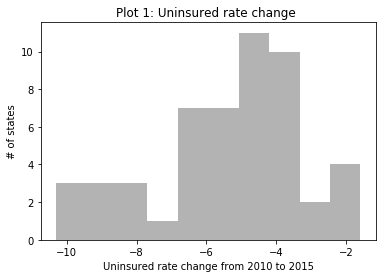

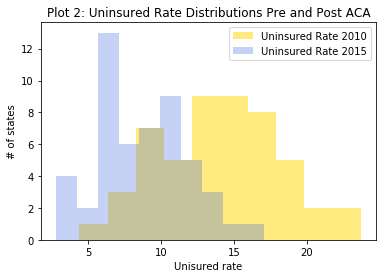

In [8]:
#so let's plot the histogram of for uninsured % change and % uninsured in 2015 and 2010

plt.hist(state_aca_df['uninsured_rate_change'], color='dimgray', alpha=.5,label='Uninsured rate change')
plt.xlabel('Uninsured rate change from 2010 to 2015')
plt.ylabel('# of states')
plt.title('Plot 1: Uninsured rate change ')
plt.show()


plt.hist(state_aca_df['uninsured_rate_2010'], color='gold',  alpha=.5,label='Uninsured Rate 2010')  # alpha just controls the opacity
plt.hist(state_aca_df['uninsured_rate_2015'], color='royalblue', alpha=.3,label='Uninsured Rate 2015')

plt.xlabel('Unisured rate')
plt.ylabel('# of states')
plt.legend(loc='upper right')
plt.title('Plot 2: Uninsured Rate Distributions Pre and Post ACA')
plt.show()


The data looks normally distributed as expected. The range in rate change is from -10.0% to +5.0%. By eye, it is hard to tell if the variance in uninsured rates is consistent between pre and post ACA measures. Let's take a closer look at the descriptive statistical variables to ensure that this is the case.

In [9]:
print('State Uninsured Rate stats - 2010')
print(state_aca_df['uninsured_rate_2010'].describe())
print("\n")
print('State Uninsured Rate stats - 2015')
print(state_aca_df['uninsured_rate_2015'].describe())

#Ratio of stf to mean pre and post ACA
print("\n")
print('Coefficient of Variation for Uninsured Rate in 2010')
print(4.164/14.180769)
print("\n")
print('Coefficient of Variation for Uninsured Rate in 2015')
print(3.142678/8.734615)

State Uninsured Rate stats - 2010
count    51.000000
mean     14.154902
std       4.201300
min       4.400000
25%      11.200000
50%      14.200000
75%      17.400000
max      23.700000
Name: uninsured_rate_2010, dtype: float64


State Uninsured Rate stats - 2015
count    51.000000
mean      8.721569
std       3.172527
min       2.800000
25%       6.200000
50%       8.600000
75%      10.900000
max      17.100000
Name: uninsured_rate_2015, dtype: float64


Coefficient of Variation for Uninsured Rate in 2010
0.2936371081145176


Coefficient of Variation for Uninsured Rate in 2015
0.3597958238571477


As expected there is larger relative variance in the state Uninsured Rate in 2015 as compared to 2010. This suggests that the effect of ACA wasn't homogenous among states. This is further corroborated by the distribution in Plot 1.

Accordingly, it should be investigated if there are any variables that predict the variance in effect size. Before this, it would be prudent to feature engineere some additional variables into this dataset.

## What variables associate with the change in % uninsured pre and post-ACA

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Change in % Uninsured')

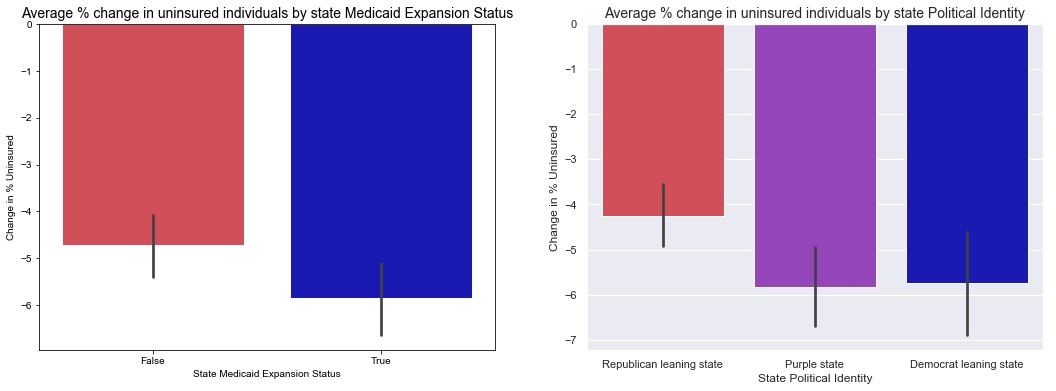

In [10]:
pol_labels= ['Republican leaning state', 'Purple state', 'Democrat leaning state']
color_scheme= ['#E63946', 'darkorchid', 'mediumblue']
binary_scheme = ['#E63946','mediumblue']


plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sns.set(style="darkgrid")
sns.barplot(state_aca_df.medicaid_expansion, state_aca_df.uninsured_rate_change, palette=binary_scheme)
plt.title('Average % change in uninsured individuals by state Medicaid Expansion Status', fontsize=14)
plt.xlabel('State Medicaid Expansion Status')
plt.ylabel('Change in % Uninsured')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.barplot(state_aca_df.political_lean, state_aca_df.uninsured_rate_change, palette=color_scheme)
plt.title('Average % change in uninsured individuals by state Political Identity', fontsize=14)
plt.xlabel('State Political Identity')
plt.xticks([0,1,2], labels=pol_labels)
plt.ylabel('Change in % Uninsured')



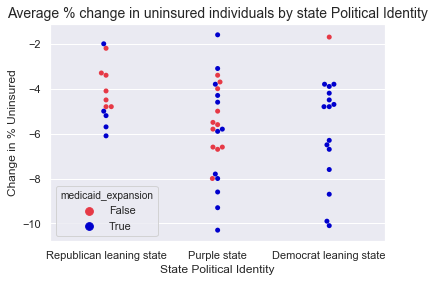

In [11]:
sns.swarmplot(x="political_lean", y="uninsured_rate_change", hue="medicaid_expansion",
              palette=['#E63946','mediumblue'], data=state_aca_df)
sns.set(style="darkgrid")
plt.title('Average % change in uninsured individuals by state Political Identity', fontsize=14)
plt.xlabel('State Political Identity')
plt.xticks([0,1,2], labels=pol_labels)
plt.ylabel('Change in % Uninsured')
plt.show()

The results suggest that state Medicaid Expansion Status and state political leaning correlate with differences in the change in % of individual's uninsured in those states. These differences should be investigated by statistical analysis in order to establish if they reach statistical significance. Before we go any further, let's investigate what other variables in this dataset correlate together.

It also seems that Medicaid Expansion status has high degree of co-variance with state political lean.


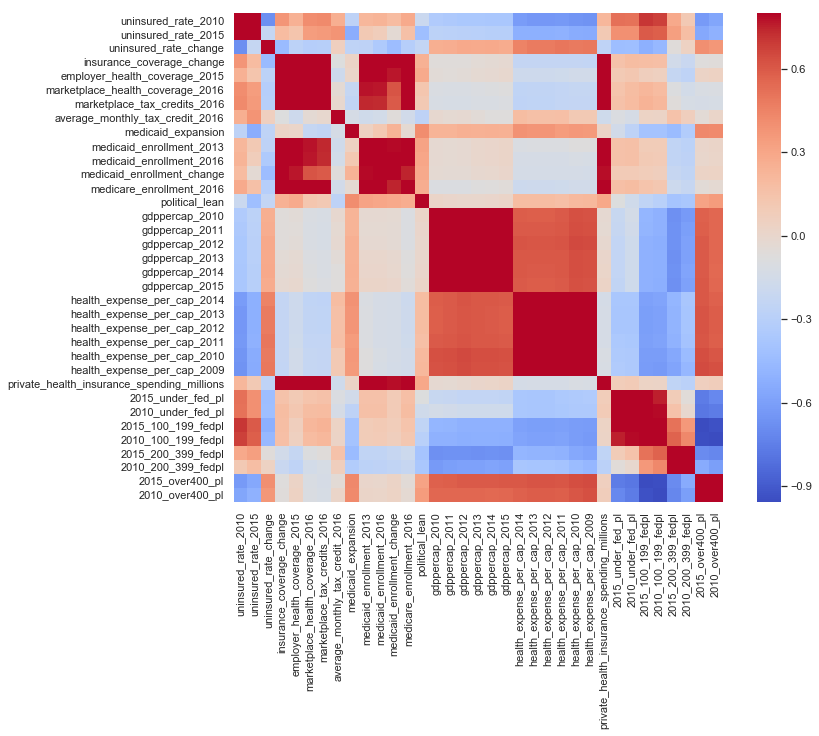

uninsured_rate_2010                          -0.677093
uninsured_rate_2015                          -0.224251
uninsured_rate_change                         1.000000
insurance_coverage_change                    -0.454530
employer_health_coverage_2015                -0.277582
marketplace_health_coverage_2016             -0.305778
marketplace_tax_credits_2016                 -0.304350
average_monthly_tax_credit_2016               0.064360
medicaid_expansion                           -0.259846
medicaid_enrollment_2013                     -0.267051
medicaid_enrollment_2016                     -0.344929
medicaid_enrollment_change                   -0.441360
medicare_enrollment_2016                     -0.308899
political_lean                               -0.241486
gdppercap_2010                                0.257893
gdppercap_2011                                0.270893
gdppercap_2012                                0.291288
gdppercap_2013                                0.284884
gdppercap_

In [12]:
# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

print(corrmatrix['uninsured_rate_change'])

It seems that most of the variables in this dataset, with the exception of the data on the distribution of individuals within 200% to 399% of the federal poverty line (2015_200_399_fedpl and 2010_200_399_fedpl) are either weakly or moderately correlated with the % change in insurance rate. There are a number of variables that reach moderate correlation namely:

-2010_100_199_fedpl 
-2015_under_fed_pl 
-health_expense_per_cap
-insurance_coverage_change
-uninsured_rate_2010


It may be worth plotting a scatterplot to visualize how these variables correlate.

Text(0, 0.5, 'Change in % Uninsured')

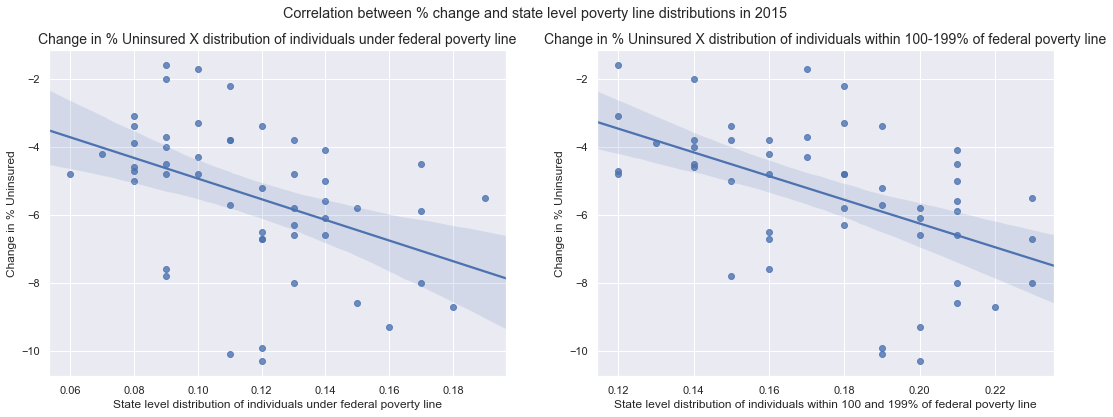

In [13]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.suptitle('Correlation between % change and state level poverty line distributions in 2015')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_under_fed_pl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals under federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals under federal poverty line')
plt.ylabel('Change in % Uninsured')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_100_199_fedpl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals within 100-199% of federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals within 100 and 199% of federal poverty line')
plt.ylabel('Change in % Uninsured')

The data seems to suggest that states with a greater share of individuals under the federal poverty line or within 100% of the federal poverty line, had greater changes in the percentage of uninsured. This seems to suggest that this endevour greatly affected the number of individuals at or near the poverty.

Text(0, 0.5, 'Change in % Uninsured')

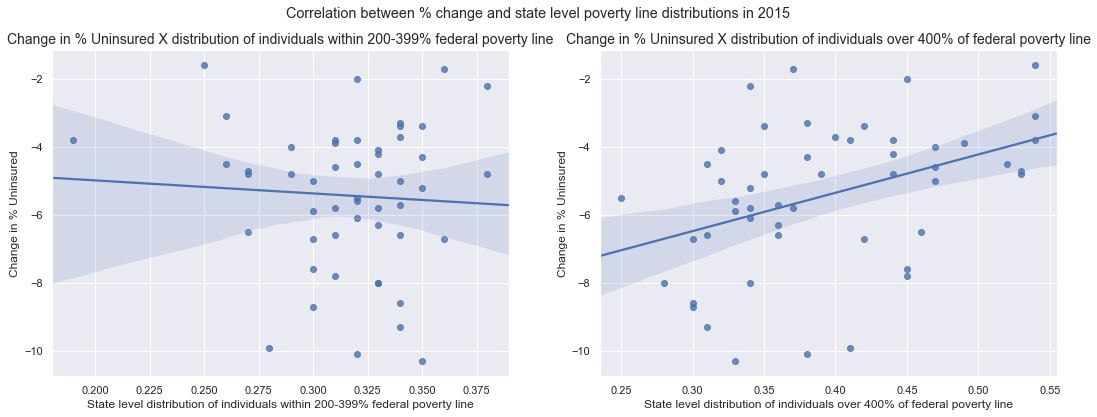

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.suptitle('Correlation between % change and state level poverty line distributions in 2015')
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_200_399_fedpl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals within 200-399% federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals within 200-399% federal poverty line')
plt.ylabel('Change in % Uninsured')

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.regplot(state_aca_df['2015_over400_pl'], state_aca_df['uninsured_rate_change'])
plt.title('Change in % Uninsured X distribution of individuals over 400% of federal poverty line', fontsize=14)
plt.xlabel('State level distribution of individuals over 400% of federal poverty line')
plt.ylabel('Change in % Uninsured')

This data however is suggestive that the state level percentage of middle class individuals (left graph) is not predictive of change in percentage uninsured. The states with higher percentages of individuals at 400% above the federal poverty line were negatively associated with changes in % uninsured. This is likely explained by the fact that these states did not have as much room to decrease the percentage of individuals without insurance (wealthy people tend to have health insurance). To compound this the ACA specifically gave marketplace incentives to individuals who fall under 400% of the federal poverty line, but not to those above.

## What is the correlation between state politics and state federal poverty level distributions?

[Text(0, 0.5, 'Distribution'), Text(0.5, 0, 'Politcal Lean')]

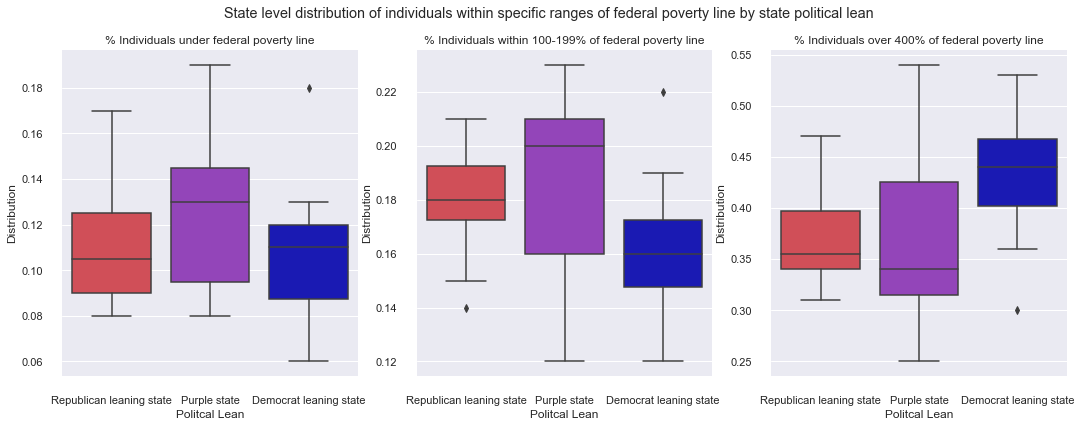

In [15]:

plt.figure(figsize=(18,6))
plt.suptitle('State level distribution of individuals within specific ranges of federal poverty line by state political lean')
plt.subplot(1, 3, 1)
ax = sns.boxplot(x='political_lean',y='2015_under_fed_pl',data=state_aca_df, palette=color_scheme)  
plt.title('% Individuals under federal poverty line')
sns.despine(offset=10, trim=True)
plt.xticks([0,1,2], labels=pol_labels)
ax.set(xlabel='Politcal Lean', ylabel='Distribution')

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='political_lean',y='2015_100_199_fedpl',data=state_aca_df, palette=color_scheme)  
plt.title('% Individuals within 100-199% of federal poverty line')
sns.despine(offset=10, trim=True)
plt.xticks([0,1,2], labels=pol_labels)
ax.set(xlabel='Politcal Lean', ylabel='Distribution')

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='political_lean',y='2015_over400_pl',data=state_aca_df, palette=color_scheme)  
plt.title('% Individuals over 400% of federal poverty line')
sns.despine(offset=10, trim=True)
plt.xticks([0,1,2], labels=pol_labels)
ax.set(xlabel='Politcal Lean', ylabel='Distribution')




Previous data in this dataset has suggested 3 specific findings:

-A negative correlation between % change in uninsured individuals and higher percentages of individuals at 400% or more of federal poverty line
-A positive correlation between % change in uninsured individuals and higher percentages of individuals at 100-199% of federal poverty line and below the federal poverty line
-Greater decreases in % of uninsured individuals in Democratic states when compared to Republican states.

Based on the observations, one might predict that Republican led states could potentially have higher rates of individuals above 400% of the federal poverty line and lower rates of individuals below the 200% and 100% thresholds for the poverty line. In the case of the former (above the 400% threshold), Democratic states in fact have higher levels. Democratic states also have lower numbers of individuals within the 100-200% threshold and a comparable number of individuals below 100% of the federal poverty line. This observations warrant further investigation in order to establish those states which have a high degree of individuals with unmet medical coverage and that will have outsized effects by strategically crafted policy.


------------------------------------------------------------------------------------------------------------------------------

## Preparing dataset for modelling

My outcome variable is change in percentage of uninsured individuals (by state) pre and post ACA.

My feature variables will include:

| Variable name in DF | Description of Variable                                  | Type      |
|---------------------|----------------------------------------------------------|-----------|
| political_lean      | Political Lean of State                                  | -0.241486 |
| 2015_under_fed_pl   | % of individuals under federal poverty line              | -0.432882 |
| 2015_100_199_fedpl  | % of individuals within 100-199% of federal poverty line | -0.512616 |
| 2015_over400_pl     | % of individuals over 400% of federal poverty line      | 0.404311  |
| uninsured_rate_2010 | The uninsured rate in 2010                               | -0.677093 |
| gdppercap_2015      | GDP Per Capita in 2015                                   | 0.277     |


My ten new features are generated below:

## 10 new features

In [16]:
politics_poverty = pd.DataFrame()
politics_poverty['political_lean']=state_aca_df['political_lean']
politics_poverty['underfpl']=state_aca_df['2015_under_fed_pl']
politics_poverty['100199fpl']=state_aca_df['2015_100_199_fedpl']
politics_poverty['over400fpl']=state_aca_df['2015_over400_pl']


scaled_politics_poverty=preprocessing.scale(politics_poverty)

pca = PCA()
pca.fit(scaled_politics_poverty)
pca_data = pca.transform(scaled_politics_poverty)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


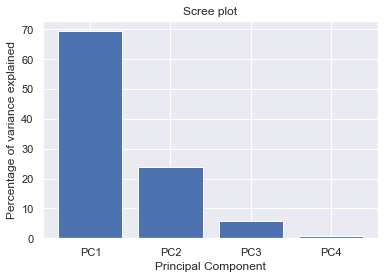

[[ 2.50815114e+00 -7.85628631e-01  8.56116469e-01 -6.29764062e-02]
 [-1.41382929e+00 -1.81749310e+00  1.16764887e-01  2.24015408e-01]
 [ 1.56678130e+00 -1.10336318e+00  3.60417597e-01  6.65105005e-02]
 [ 2.82469547e+00  5.59917616e-01  1.68225644e-01  1.03626999e-01]
 [-8.13642558e-02  1.26257574e+00 -2.10244989e-01  4.17196232e-01]
 [-1.37451159e+00 -4.28342186e-01 -3.94101706e-02 -3.26307476e-02]
 [-2.79986837e+00 -6.03593150e-01  5.71036758e-01  7.57780018e-02]
 [-1.23667068e+00  1.05837978e+00  1.29055133e-01 -2.36847819e-01]
 [-1.54989807e+00 -6.34063282e-02  1.67492607e+00  3.76424163e-01]
 [ 1.29164399e+00  1.18936687e-01 -2.98786214e-01  2.92587820e-01]
 [ 1.45345725e+00  2.86441663e-01  3.29137375e-01 -1.52644949e-02]
 [-2.51855720e+00  7.14315966e-01 -1.38211200e-01 -1.70329075e-01]
 [ 1.79783326e+00  7.43511218e-02 -1.01784424e+00  4.53530640e-01]
 [-7.21309907e-01  1.18195312e+00  1.62815537e-01 -2.08886153e-01]
 [ 1.02921820e+00 -1.32483455e+00 -6.04305872e-02 -1.01315828e

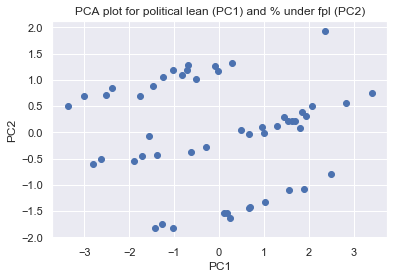

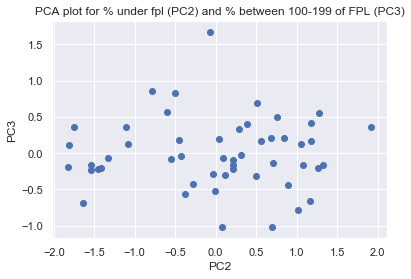

In [17]:
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of variance explained')
plt.xlabel('Principal Component')
plt.title('Scree plot')
plt.show()

# at 850 in video www.youtube.com/watch?v=Lsue2gEM9D0
print(pca_data)

politics_poverty_pca_df = pd.DataFrame(pca_data, columns=labels)

plt.scatter(politics_poverty_pca_df.PC1, politics_poverty_pca_df.PC2)
plt.title('PCA plot for political lean (PC1) and % under fpl (PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(politics_poverty_pca_df.PC2, politics_poverty_pca_df.PC3)
plt.title('PCA plot for % under fpl (PC2) and % between 100-199 of FPL (PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

In [18]:
#Medicaid * Politics interaction

medicaidXpolitics=state_aca_df['political_lean']

for row in state_aca_df['medicaid_expansion']:
    if row == False:
       #when the row is false, they did not expand medicaid so subtract 1
        medicaidXpolitics = medicaidXpolitics - 1
    # else add 1 when they expanded medicaid
    else:
        medicaidXpolitics = medicaidXpolitics + 1

state_aca_df['medicaidXpolitics'] = medicaidXpolitics

#feature 5 - percentage of individuals under 199% of federal poverty line:

state_aca_df['2015_under199_fed_pl'] = state_aca_df['2015_under_fed_pl'] + state_aca_df['2015_100_199_fedpl']

#feature 6

state_aca_df['2015_over200_fed_pl'] = state_aca_df['2015_200_399_fedpl'] + state_aca_df['2015_over400_pl']

#feature 7

state_aca_df['ratio_rich_to_poor']=state_aca_df['2015_over200_fed_pl']/state_aca_df['2015_under199_fed_pl']

#add PCA results back into original table so we can do a new correlation matrix

state_aca_df['PC1']=politics_poverty_pca_df['PC1'].apply(pd.to_numeric)
state_aca_df['PC2']=politics_poverty_pca_df['PC2'].apply(pd.to_numeric)
state_aca_df['PC3']=politics_poverty_pca_df['PC3'].apply(pd.to_numeric)




My new features are:

1) PC1, 2) PC2, 3) PC3 - the outputs of a PCA (with State Political Lean, % individuals under federal poverty line, between 100-199% of federal poverty line). PC4 was omitted as it was not a significant component of the shared variance within those samples.

Reason: Reduces dimensionality, still retains shared variance of the included variables


4) Medicaid X Politcs - a scalled categorical variable where:

-1: Republican and did not expand medicaid
0: Republic or Purple and did not expand medicaid
1: Republican that expanded medicaid or purple that did not
2: Purple state that expanded medicaid or democratic that did not.
3: Democratic state that expanded medicaid

Reason: Again, reduces dimensionality and includes the information of these two variables which have a clear interdependence.

5) Percentage of individuals under 199% of federal poverty line

Reason: Reduces dimensionality. Meaningful data as the cutoff put is 200% of the federal poverty line for market incentives.

6) Percentage of individuals over 200% of federal poverty line

Reason: See above

Let's re do the correlation matrix with these variables:

7) Ratio 'rich' to poor (ratio of individuals over 200% of federal poverty to individuals under 200% of federal poverty line

Further reduces dimensionality includes key info pertaining to reduction in individuals uninsured.

8, 9, 10: I've feature engineered lot's of features into this data set...i'm going to stop here for fear of encountering the curse of dimensionality...

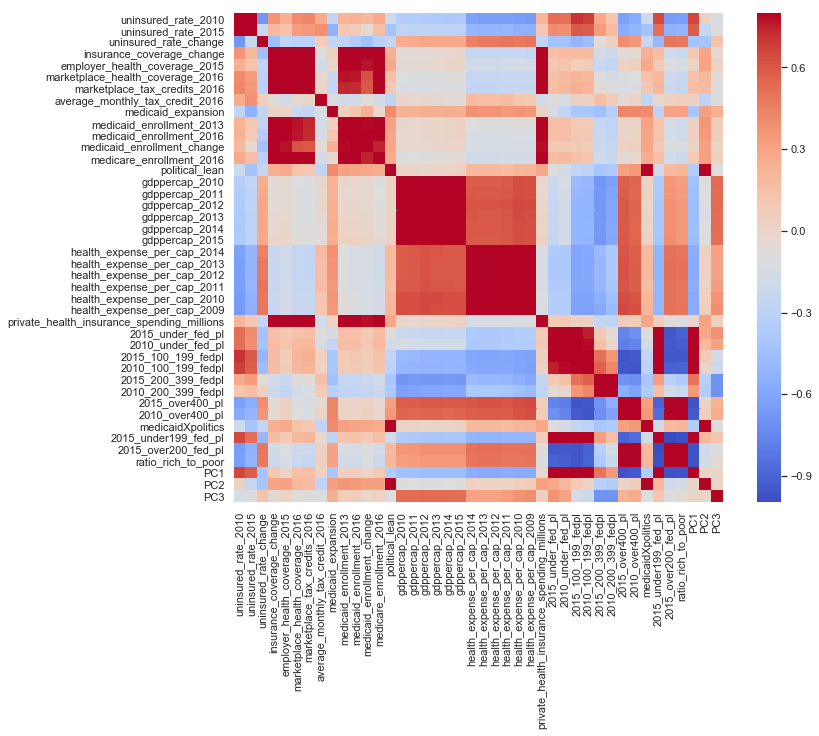

uninsured_rate_change                         1.000000
uninsured_rate_2010                           0.677093
2015_100_199_fedpl                            0.512616
health_expense_per_cap_2011                   0.498907
2015_under199_fed_pl                          0.496695
health_expense_per_cap_2009                   0.496485
2015_over200_fed_pl                           0.494866
health_expense_per_cap_2010                   0.490401
ratio_rich_to_poor                            0.488840
health_expense_per_cap_2013                   0.481453
health_expense_per_cap_2012                   0.481453
2010_100_199_fedpl                            0.467727
health_expense_per_cap_2014                   0.455196
insurance_coverage_change                     0.454530
medicaid_enrollment_change                    0.441360
2015_under_fed_pl                             0.432882
PC1                                           0.426520
2010_under_fed_pl                             0.424199
PC2       

In [19]:
# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

print(corrmatrix['uninsured_rate_change'].abs().sort_values(ascending=False))

Top 5 are:

uninsured_rate_2010                           0.677093
2015_100_199_fedpl                            0.512616
health_expense_per_cap_2011                   0.498907
2015_under199_fed_pl                          0.496695
health_expense_per_cap_2009                   0.496485

I've picked these as they are the most correlated with the outcome variable.

# Let's try random forest and decision trees and see how they do with this model.

First of all, let's try running random forest on the whole dataset and see how it fairs. If we need to re-adjust the model so that we only use the most highly correlated variables (listed above), then let's persue that option:

In [62]:
#remove any data relating to rate changes
rf_regression_data=state_aca_df.drop('State', 1)
rf_regression_data=rf_regression_data.drop('uninsured_rate_change', 1)
rf_regression_data=rf_regression_data.drop('uninsured_rate_change', 1)
rf_regression_data=rf_regression_data.drop('uninsured_rate_2010', 1)
rf_regression_data=rf_regression_data.drop('uninsured_rate_2015', 1)

In [64]:
#quick check that everything is in order...
rf_regression_data.head()

,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,average_monthly_tax_credit_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,...,2010_200_399_fedpl,2015_over400_pl,2010_over400_pl,medicaidXpolitics,2015_under199_fed_pl,2015_over200_fed_pl,ratio_rich_to_poor,PC1,PC2,PC3
0,215000,2545000,165534,152206,310,False,799176.0,910775,111599.0,989855,...,0.32,0.31,0.30,13,0.38,0.63,1.657895,2.508151,-0.785629,0.856116
1,36000,390000,17995,16205,750,True,122334.0,166625,44291.0,88966,...,0.30,0.47,0.46,13,0.23,0.77,3.347826,-1.413829,-1.817493,0.116765
2,410000,3288000,179445,124346,230,True,1201770.0,1716198,514428.0,1175624,...,0.32,0.34,0.32,13,0.34,0.66,1.941176,1.566781,-1.103363,0.360418
3,234000,1365000,63357,56843,306,True,556851.0,920194,363343.0,606146,...,0.32,0.28,0.27,14,0.40,0.61,1.525000,2.824695,0.559918,0.168226
4,3826000,19552000,1415428,1239893,309,True,7755381.0,11843081,4087700.0,5829777,...,0.29,0.41,0.38,15,0.31,0.69,2.225806,-0.081364,1.262576,-0.210245


# DT

In [105]:
# This is the model we'll be using.
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.4, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.23809523809523808


Not especially, accurate. Let's try again.

In [107]:
# This is the model we'll be using.
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.4, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=4,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.19047619047619047


Using more features has no impact.

In [108]:
# This is the model we'll be using.
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.4, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=8,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.19047619047619047


Nor does changing max depth. As a final measure let's try to make the test size bigger as we're working with a small sample size.

In [110]:
# This is the model we'll be using.
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# A convenience for displaying visualizations.
from IPython.display import Image
import time
start_time = time.time()

# Packages for rendering our tree.
import pydotplus
import graphviz

#split data

X = rf_regression_data
X = X.dropna(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, state_aca_df['uninsured_change_cat'], test_size=0.7, random_state=1)


# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=8,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("--- %s seconds ---" % (time.time() - start_time))

Accuracy: 0.1111111111111111
--- 0.00598454475402832 seconds ---


# RF

In [65]:
import time
start_time = time.time()

rf= ensemble.RandomForestRegressor()
X = rf_regression_data
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_rate_change']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.32485671 0.31765537 0.21718424 0.22963656 0.03541418]
--- 0.057828664779663086 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 

Works, but there's a pretty large variance here. Also not a huge difference between the RF and DT. The DT runs significantly faster and the RF is slightly more accurate.

Perhaps a product of having n=52, which is a relatively small sample size. Maybe I could generate some synthetic data? Also worth considering trying this as a classificaiton and creating bins for changes in uninsured rate.

# Rerun RF as a classifer with % change in uninsured as a scaled categorical variable

In [22]:
state_aca_df['uninsured_rate_change'].quantile(q=0)
state_aca_df['uninsured_rate_change'].quantile(q=.1)


-8.6

In [66]:
#might be better to create a categorical variable that includes neutral states
uninsured_change_cat=[]

for row in state_aca_df['uninsured_rate_change']:
    if row <=-8.6:
        uninsured_change_cat.append(8)
    elif row <= -6.7 and row >=-8.6:
        uninsured_change_cat.append(7)
    elif row <= -6.3 and row >=-6.7:
        uninsured_change_cat.append(6)
    elif row <= -5.7 and row >=-6.3:
        uninsured_change_cat.append(5)
    elif row <= -5.0 and row >=-5.7:
        uninsured_change_cat.append(4)
    elif row <= -4.7 and row >=-5.0:
        uninsured_change_cat.append(3)
    elif row <= -4.2 and row >=-4.7:
        uninsured_change_cat.append(2)
    elif row <= -3.8 and row >=-4.2:
        uninsured_change_cat.append(1)
    elif row >= -3.8:
        uninsured_change_cat.append(0)
    #create a column based on this output
state_aca_df['uninsured_change_cat'] = uninsured_change_cat

print(state_aca_df['uninsured_change_cat'])

0     2
1     4
2     5
3     7
4     8
5     7
6     0
7     1
8     1
9     7
10    5
11    1
12    7
13    7
14    4
15    2
16    3
17    8
18    5
19    0
20    3
21    0
22    6
23    2
24    4
25    0
26    5
27    0
28    8
29    3
30    2
31    8
32    3
33    4
34    0
35    5
36    4
37    8
38    1
39    6
40    6
41    0
42    1
43    6
44    3
45    2
46    1
47    7
48    8
49    0
50    0
Name: uninsured_change_cat, dtype: int64


In [70]:
start_time = time.time()



rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.30617257 0.43363636 0.28294118 0.11705426 0.2364486 ]
--- 0.05585026741027832 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 

Little bit better, slightly less variance, no real difference in execution speed. Still not completely reliable though. I'm going to try to reduce dimensionality a little bit more.

In [71]:
#let's check what we can remove..
rf_regression_data['uninsured_change_cat'] = state_aca_df['uninsured_change_cat']

# Make the correlation matrix.
corrmatrix = state_aca_df.corr()

print(corrmatrix['uninsured_change_cat'].abs().sort_values(ascending=False))

uninsured_change_cat                          1.000000
uninsured_rate_change                         0.951393
uninsured_rate_2010                           0.691838
2015_100_199_fedpl                            0.533331
2015_under199_fed_pl                          0.525881
2015_over200_fed_pl                           0.521096
ratio_rich_to_poor                            0.514728
2010_100_199_fedpl                            0.504546
health_expense_per_cap_2009                   0.475121
health_expense_per_cap_2011                   0.470429
2015_under_fed_pl                             0.468024
health_expense_per_cap_2010                   0.467017
2010_under_fed_pl                             0.460204
health_expense_per_cap_2013                   0.455559
health_expense_per_cap_2012                   0.455559
PC1                                           0.454710
health_expense_per_cap_2014                   0.433905
2015_over400_pl                               0.428995
insurance_

In [47]:
#remove the 4 lowest correlates and the uninsured rate data and then let's run again

rf_regression_data_reduced=rf_regression_data.drop('2010_200_399_fedpl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('average_monthly_tax_credit_2016', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_200_399_fedpl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('PC3', 1)

In [72]:
rf_regression_data_reduced.head()

,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,political_lean,...,2015_100_199_fedpl,2010_100_199_fedpl,2015_over400_pl,2010_over400_pl,medicaidXpolitics,2015_under199_fed_pl,2015_over200_fed_pl,ratio_rich_to_poor,PC1,PC2
0,215000,2545000,165534,152206,False,799176.0,910775,111599.0,989855,0,...,0.21,0.21,0.31,0.30,13,0.38,0.63,1.657895,2.508151,-0.785629
1,36000,390000,17995,16205,True,122334.0,166625,44291.0,88966,0,...,0.15,0.16,0.47,0.46,13,0.23,0.77,3.347826,-1.413829,-1.817493
2,410000,3288000,179445,124346,True,1201770.0,1716198,514428.0,1175624,0,...,0.20,0.21,0.34,0.32,13,0.34,0.66,1.941176,1.566781,-1.103363
3,234000,1365000,63357,56843,True,556851.0,920194,363343.0,606146,1,...,0.23,0.25,0.28,0.27,14,0.40,0.61,1.525000,2.824695,0.559918
4,3826000,19552000,1415428,1239893,True,7755381.0,11843081,4087700.0,5829777,2,...,0.19,0.20,0.41,0.38,15,0.31,0.69,2.225806,-0.081364,1.262576


In [75]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.49465708 0.57560606 0.22647059 0.19596899 0.44193925]
--- 0.0568850040435791 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 

Again, looks somewhat better. Let's try and further reduce dimensionality and try a final time.

In [111]:
#let's take a look at what can still be removed
rf_regression_data_reduced.head()

,insurance_coverage_change,employer_health_coverage_2015,marketplace_health_coverage_2016,marketplace_tax_credits_2016,medicaid_expansion,medicaid_enrollment_2013,medicaid_enrollment_2016,medicaid_enrollment_change,medicare_enrollment_2016,political_lean,...,2015_100_199_fedpl,2010_100_199_fedpl,2015_over400_pl,2010_over400_pl,medicaidXpolitics,2015_under199_fed_pl,2015_over200_fed_pl,ratio_rich_to_poor,PC1,PC2
0,215000,2545000,165534,152206,False,799176.0,910775,111599.0,989855,0,...,0.21,0.21,0.31,0.30,13,0.38,0.63,1.657895,2.508151,-0.785629
1,36000,390000,17995,16205,True,122334.0,166625,44291.0,88966,0,...,0.15,0.16,0.47,0.46,13,0.23,0.77,3.347826,-1.413829,-1.817493
2,410000,3288000,179445,124346,True,1201770.0,1716198,514428.0,1175624,0,...,0.20,0.21,0.34,0.32,13,0.34,0.66,1.941176,1.566781,-1.103363
3,234000,1365000,63357,56843,True,556851.0,920194,363343.0,606146,1,...,0.23,0.25,0.28,0.27,14,0.40,0.61,1.525000,2.824695,0.559918
4,3826000,19552000,1415428,1239893,True,7755381.0,11843081,4087700.0,5829777,2,...,0.19,0.20,0.41,0.38,15,0.31,0.69,2.225806,-0.081364,1.262576


In [ ]:
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_under199_fed_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_over200_fed_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2010_over400_pl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2010_100_199_fedpl', 1)
rf_regression_data_reduced=rf_regression_data_reduced.drop('2015_100_199_fedpl', 1)



In [116]:
start_time = time.time()

rf_rc2= ensemble.RandomForestClassifier()
X = rf_regression_data_reduced
X = X.dropna(axis=1)
Y = state_aca_df['uninsured_change_cat']

print(cross_val_score(rf, X, Y, cv=5))
print("--- %s seconds ---" % (time.time() - start_time))

[0.5069469  0.56181818 0.22808824 0.08077519 0.32932243]
--- 0.07382392883300781 seconds ---


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 

Still no major difference. Will try generating synthetic data next.